# Titanic: Machine Learning from Disaster

Setting path for data.

In [2]:
from pathlib import Path
import os

path = Path('../input/titanic')

Install fastai library if not already installed.

In [3]:
# !pip install -Uqq fastai

- It is generally bad practice to `import *`, however, everything in this notebook is done using the fastai library
- There is no manual feature engineering
- There is no data exploration (done previously)
- Since the dataset is tabular, import the fastai tabular library
- No random seed is set

In [4]:
from fastai.tabular.all import * 

In [5]:
df = pd.read_csv(path/'train.csv')

### Adding a few features
- This [notebook](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/) on kaggle goes into advanced feature engineering 
- Below are some of the most interesting features from that notebook
- Add most interesting features to the to the df

In [6]:
def add_feat(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_feat(df)

Use fastai's `RandomSplitter()` to create a training and validation set.

In [7]:
splits = RandomSplitter()(df)

- fastai automates most of the feature engineering and just requires initialisation of `DataLoader`
- fastai's `DataLoader` is an extension of PyTorch's `DataLoader` class but comes with more functionality and flexibility
- fastai requires a `DataLoader` to build a model
- There are two ways to build `DataLoader`: first is to as its own class with a defined `DataSet` class, which is done below; second is as a subclass of the `DataBlock`
- The `DataLoader` allows for building a quick model, with little manual input, and an adjustable pipeline to manipulate data without changing the raw data
- `DataLoader` requires information about: 
    1. dataset, `df`
    2. splitting of the data, `splits`
    3. feature engineering, `procs`
    4. catorgorical independent features, `cat_names`
    5. continuous independent features, `cont_names`
    6. the dependent variable, `y_names`
    7. this is a classification model, and therefore require `CategoryBlock()`

In [8]:
# dataloader
dls = TabularPandas( 
    df, 
    splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", 
    y_block = CategoryBlock(),
).dataloaders(path=".")

- Train model using `tabular_learner`, since this is tabular data
- Define the metrics as `accuracy`
- `[10,10]` hidden layers

In [9]:
learn = tabular_learner(dls, metrics=accuracy, layers=[20,20])

- fastai can also simply help determine the learning rate
- A value between the `slide` and the `valley` is recommended as the learning rate

SuggestedLRs(slide=0.0831763744354248, valley=0.0063095735386013985)

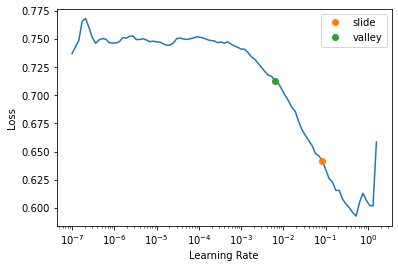

In [10]:
# determining learning rate
learn.lr_find(suggest_funcs=(slide,valley))

Fit the model for 10 epochs with a learning rate of 0.01

In [11]:
learn.fit(10, lr=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.567813,0.592642,0.707865,00:00
1,0.501392,0.486343,0.786517,00:00
2,0.463866,0.447387,0.797753,00:00
3,0.438455,0.435036,0.797753,00:00
4,0.425546,0.427877,0.786517,00:00
5,0.414996,0.427678,0.797753,00:00
6,0.403659,0.426099,0.786517,00:00
7,0.396355,0.417380,0.797753,00:00
8,0.388587,0.449755,0.792135,00:00
9,0.381978,0.415559,0.820225,00:00


At the time of running this code, the accuracy was equal to `0.853933`.

### Submitting to kaggle

Load in `test.csv`.

In [12]:
tst_df = pd.read_csv(path/'test.csv')

- Fill `Fare` with the mean
- Call `add_feat()` to add interesting features discussed above

In [13]:
tst_df['Fare'] = tst_df.Fare.fillna(tst_df['Fare'].mean())
add_feat(tst_df)

- Not required to specify any of the processing steps initiated in `DataLoaders`
- All information is saved in the learner
- Use `test_dl()` method to apply the same steps

In [14]:
tst_dl = learn.dls.test_dl(tst_df)

Use `get_preds()` to get predictions for the test set.

In [15]:
preds,_ = learn.get_preds(dl=tst_dl)

In [16]:
preds

tensor([[0.8653, 0.1347],
        [0.8998, 0.1002],
        [0.9746, 0.0254],
        [0.9184, 0.0816],
        [0.2504, 0.7496],
        [0.9523, 0.0477],
        [0.4107, 0.5893],
        [0.9332, 0.0668],
        [0.2497, 0.7503],
        [0.8928, 0.1072],
        [0.9454, 0.0546],
        [0.8178, 0.1822],
        [0.0119, 0.9881],
        [0.9953, 0.0047],
        [0.0211, 0.9789],
        [0.0215, 0.9785],
        [0.8737, 0.1263],
        [0.9052, 0.0948],
        [0.8248, 0.1752],
        [0.3521, 0.6479],
        [0.8959, 0.1041],
        [0.2450, 0.7550],
        [0.0402, 0.9598],
        [0.7086, 0.2914],
        [0.1290, 0.8710],
        [0.9911, 0.0089],
        [0.0198, 0.9802],
        [0.9011, 0.0989],
        [0.5973, 0.4027],
        [0.9389, 0.0611],
        [0.9826, 0.0174],
        [0.9235, 0.0765],
        [0.4072, 0.5928],
        [0.2387, 0.7613],
        [0.5706, 0.4294],
        [0.9117, 0.0883],
        [0.6332, 0.3668],
        [0.6047, 0.3953],
        [0.9

In [17]:
tst_df['Survived'] = np.array((preds[:,1]>0.5).int())

Submit to kaggle.

In [18]:
submission_df = tst_df[['PassengerId', 'Survived']]
submission_df.to_csv('submssion.csv', index=False)

### Ensembling

- The model can be created into an ensemble, essentially stacking models on top of each other
- Use five models in this ensemble

In [19]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

learns = [ensemble() for _ in range(5)]

Take the average prediction and calculate accuracy.

In [24]:
ens_preds = torch.stack(learns).mean(0)
preds = (ens_preds[:,1]>0.5).int()